## Extract tracer transports and save into files


This notebook extracts the tracer trabnsport through several cross sections along the shelf, across the shelf and vertically, from canyon to shelf. See plot below. Transport is divided in advective and diffusive by the model and stored in files called Flux01Glob.nc (01 is the tracer number for tracer 1).

Advective tracer transport $\Phi_{Tadv}=C\vec{u}\cdot\vec{a}$ 

Diffusive tracer transport $\Phi_{Tdiff}$, includes diffusion due to advection scheme)

| variable  | dims | units | description |
|:---------:|:---------:|:---------:|:---------:|
| UTRAC01   |   (T, Zmd000090, Y, Xp1) | Mol/L.m/s | Zonal Mass-Weighted Transp of Tr1 |
| VTRAC01   |   (T, Zmd000090, Yp1, X) | Mol/L.m/s | Meridional Mass-Weighted Transp of Tr1 |
| WTRAC01   |   (T, Zmd000090, Y, X)   | Mol/L.m/s | Vertical Mass-Weighted Transp of Tr1 |  
| ADVrTr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Zonal Advective Flux of Tr1 |
| ADVxTr01  |   (T, Zmd000090, Y, Xp1) | Mol/L.m^3/s| Meridional Advective Flux of Tr1 |
| ADVyTr01  |   (T, Zmd000090, Yp1, X) | Mol/L.m^3/s| Vertical Advective Flux of Tr1 |
| DFrETr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Vertical Diffusive Flux of Tr1 (Explicit part) |
| DFrITr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Vertical Diffusive Flux of Tr1 (Implicit part) |
| DFxETr01  |   (T, Zmd000090, Y, Xp1) | Mol/L.m^3/s| Zonal Diffusive Flux of Tr1 |
| DFyETr01  |   (T, Zmd000090, Yp1, X) | Mol/L.m^3/s| Meridional Diffusive Flux of Tr1 |


* run##water_CS_transports.nc - cross-shelf and vertical transports

There is one of each files for every run.

In [1]:
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import xarray as xr

In [2]:
# Define slices and positions of cross sections 
CS1_x_slice = slice(0, 59)
CS2_x_slice = slice(60, 119)
CS3_x_slice = slice(120, 239)
CS4_x_slice = slice(240, 299)
CS5_x_slice = slice(300, 359)
CSCOAST_x_slice = slice(0, 359)

CS_y_coast = 358
CS1_y_ind = 227

AS1_y_slice = slice(227, 266)
AS2_y_slice = slice(267, 298)
AS3_y_slice = slice(299, 359)

AS1_x_ind = 119
AS1b_x_ind = 239

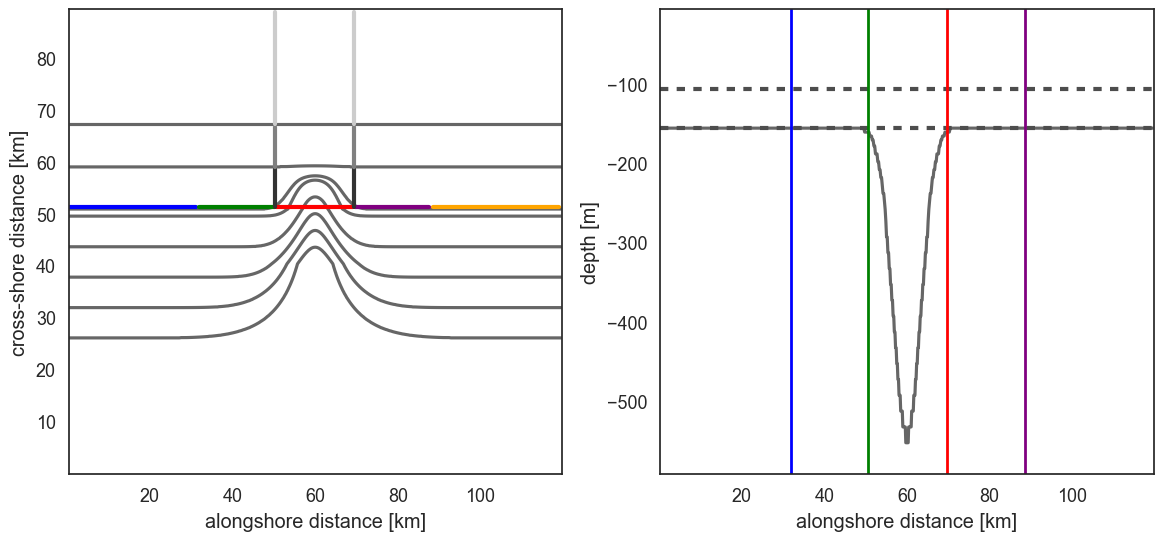

In [3]:
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

sns.set_style(style='white')
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].contour(grid.X/1000,grid.Y/1000,grid.Depth,[50,100,150,200,400,600,800,1000], colors='0.4')

ax[0].plot(grid.XC[CS1_y_ind,CS1_x_slice]/1000,grid.YC[CS1_y_ind,CS1_x_slice]/1000, 'b-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS2_x_slice]/1000,grid.YC[CS1_y_ind,CS2_x_slice]/1000, 'g-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS3_x_slice]/1000,grid.YC[CS1_y_ind,CS3_x_slice]/1000, 'r-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS4_x_slice]/1000,grid.YC[CS1_y_ind,CS4_x_slice]/1000, '-',color='purple', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS5_x_slice]/1000,grid.YC[CS1_y_ind,CS5_x_slice]/1000, '-', color='orange', linewidth=3)

ax[0].plot(grid.XC[AS1_y_slice,AS1_x_ind]/1000,grid.YC[AS1_y_slice,AS1_x_ind]/1000, '-', color='0.2',linewidth=3)
ax[0].plot(grid.XC[AS2_y_slice,AS1_x_ind]/1000,grid.YC[AS2_y_slice,AS1_x_ind]/1000, '-', color='0.5',linewidth=3)
ax[0].plot(grid.XC[AS3_y_slice,AS1_x_ind]/1000,grid.YC[AS3_y_slice,AS1_x_ind]/1000, '-', color='0.8',linewidth=3)

ax[0].plot(grid.XC[AS1_y_slice,AS1b_x_ind]/1000,grid.YC[AS1_y_slice,AS1b_x_ind]/1000, '-', color='0.2', linewidth=3)
ax[0].plot(grid.XC[AS2_y_slice,AS1b_x_ind]/1000,grid.YC[AS2_y_slice,AS1b_x_ind]/1000, '-', color='0.5', linewidth=3)
ax[0].plot(grid.XC[AS3_y_slice,AS1b_x_ind]/1000,grid.YC[AS3_y_slice,AS1b_x_ind]/1000, '-', color='0.8', linewidth=3)

ax[0].set_xlabel('alongshore distance [km]')
ax[0].set_ylabel('cross-shore distance [km]')

ax[1].contour(grid.XC[227,:]/1000,grid.RC[:60],grid.HFacC[:60,227,:],[0],colors='0.4')
ax[1].plot([grid.X[0]/1000,grid.X[359]/1000],[grid.RC[20],grid.RC[20]], '--', color='0.3', linewidth=3)
ax[1].plot([grid.X[0]/1000,grid.X[359]/1000],[grid.RC[30],grid.RC[30]], '--', color='0.3', linewidth=3)

ax[1].axvline(x=grid.X[60]/1000,color='b', linewidth=2)
ax[1].axvline(x=grid.X[120]/1000,color='g', linewidth=2)
ax[1].axvline(x=grid.X[240]/1000,color='r', linewidth=2)
ax[1].axvline(x=grid.X[300]/1000,color='purple', linewidth=2)


ax[1].set_xlabel('alongshore distance [km]')
ax[1].set_ylabel('depth [m]')


In [4]:
def calc_trac_transport_CS(flux_component, x_slice, y_slice, dim_name,zini=0,zfin=30):
    '''
    INPUT:
    flux_component: xarray, flux component perpendicular to cross section (e.g. unstagger_xarray(flux38.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    dim_name: str, name of the dimension along which to sum.
    
    '''
    return (((flux_component.isel(Yp1=y_slice, X=x_slice)).sum(dim=dim_name)).isel(
            Zmd000090=slice(zini,zfin))).sum(dim='Zmd000090')

 

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty



In [5]:
#set up paths to grid files
grid_Can_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid_NoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'


In [6]:
import os
import sys
lib_path = os.path.abspath('../PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [7]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [14]:
records_sel = [records[18], records[19], records[20]]
recordsNoC_sel = [recordsNoC[18], recordsNoC[19], recordsNoC[20]]

### Save tracer transport

In [10]:
# CNT runs, this should be a function!

grid = xr.open_dataset(grid_Can_file)

ii = 0

for rec in records_sel:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/FluxTR01Glob.nc' %(rec.exp_code,rec.run_num))
    flux = xr.open_dataset(filename)
    
    advCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
    advCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
    advCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
    advCS3b_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'),
                                          CS3_x_slice, CS1_y_ind, 'X',zini=30,zfin=90)
    advCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
    advCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')

    
    vel_vert = (unstagger_xarray(flux.ADVrTr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    advVert_flux = (vel_vert).sum(dim='Y').sum(dim='X')
    
    
    advVert_flux.name = 'Vert_adv_trans_sb'
    advVert_flux.attrs['units'] = 'Mol/lm3/s'

    advCS1_flux.name = 'CS1_adv_trans'
    advCS1_flux.attrs['units'] = '(Mol/l)m3/s'
    advCS2_flux.name = 'CS2_adv_trans'
    advCS2_flux.attrs['units'] = '(Mol/l)m3/s'
    advCS3_flux.name = 'CS3_adv_trans'
    advCS3_flux.attrs['units'] = 'm3/s'
    advCS3b_flux.name = 'CS3b_adv_trans'
    advCS3b_flux.attrs['units'] = 'm3/s'
    advCS4_flux.name = 'CS4_adv_trans'
    advCS4_flux.attrs['units'] = 'm3/s'
    advCS5_flux.name = 'CS5_adv_trans'
    advCS5_flux.attrs['units'] = 'm3/s'
   
    
    objectsCS = [advCS1_flux, advCS2_flux,advCS3_flux,advCS3b_flux,advCS4_flux,advCS5_flux,advVert_flux]
               
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'advTracer_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    print(DS_CS_path)
    ii=ii+1
    



/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run03advTracer_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run05advTracer_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run07advTracer_CS_transports.nc


In [15]:
# No canyon, advective
ii = 0

for rec in recordsNoC_sel:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/FluxTR01Glob.nc' %(rec.exp_code,rec.run_num))
    flux = xr.open_dataset(filename)
    
    advCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
    advCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
    advCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
    advCS3b_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'),
                                          CS3_x_slice, CS1_y_ind, 'X',zini=30,zfin=90)
    advCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
    advCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')

    
    vel_vert = (unstagger_xarray(flux.ADVrTr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    advVert_flux = (vel_vert).sum(dim='Y').sum(dim='X')
    
    
    advVert_flux.name = 'Vert_adv_trans_sb'
    advVert_flux.attrs['units'] = 'm3/s'

    advCS1_flux.name = 'CS1_adv_trans'
    advCS1_flux.attrs['units'] = 'm3/s'
    advCS2_flux.name = 'CS2_adv_trans'
    advCS2_flux.attrs['units'] = 'm3/s'
    advCS3_flux.name = 'CS3_adv_trans'
    advCS3_flux.attrs['units'] = 'm3/s'
    advCS3b_flux.name = 'CS3b_adv_trans'
    advCS3b_flux.attrs['units'] = 'm3/s'
    advCS4_flux.name = 'CS4_adv_trans'
    advCS4_flux.attrs['units'] = 'm3/s'
    advCS5_flux.name = 'CS5_adv_trans'
    advCS5_flux.attrs['units'] = 'm3/s'
   
    
    objectsCS = [advCS1_flux, advCS2_flux,advCS3_flux,advCS3b_flux,advCS4_flux,advCS5_flux,advVert_flux]
               
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'advTracer_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    print(DS_CS_path)
    ii=ii+1
    



/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run04advTracer_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run06advTracer_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run08advTracer_CS_transports.nc


In [12]:
# Canyon, Diffusive 
ii = 0

for rec in records_sel:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/FluxTR01Glob.nc' %(rec.exp_code,rec.run_num))
    flux = xr.open_dataset(filename)
    
    difCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
    difCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
    difCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
    difCS3b_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'),
                                          CS3_x_slice, CS1_y_ind, 'X',zini=30,zfin=90)
    difCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
    difCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')

    
    flux_vert_E = (unstagger_xarray(flux.DFrETr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    flux_vert_I = (unstagger_xarray(flux.DFrITr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    difVert_flux = (flux_vert_E+flux_vert_I).sum(dim='Y').sum(dim='X')
    
    difVert_flux.name = 'Vert_dif_trans_sb'
    difVert_flux.attrs['units'] = 'm3/s'

    difCS1_flux.name = 'CS1_dif_trans'
    difCS1_flux.attrs['units'] = 'm3/s'
    difCS2_flux.name = 'CS2_dif_trans'
    difCS2_flux.attrs['units'] = 'm3/s'
    difCS3_flux.name = 'CS3_dif_trans'
    difCS3_flux.attrs['units'] = 'm3/s'
    difCS3b_flux.name = 'CS3b_dif_trans'
    difCS3b_flux.attrs['units'] = 'm3/s'
    difCS4_flux.name = 'CS4_dif_trans'
    difCS4_flux.attrs['units'] = 'm3/s'
    difCS5_flux.name = 'CS5_dif_trans'
    difCS5_flux.attrs['units'] = 'm3/s'
   
    
    objectsCS = [difCS1_flux, difCS2_flux,difCS3_flux,difCS3b_flux,difCS4_flux,difCS5_flux,difVert_flux]
               
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'difTracer_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    print(DS_CS_path)
    ii=ii+1
    



/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run03difTracer_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run05difTracer_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run07difTracer_CS_transports.nc


In [16]:
# Canyon, Diffusive 
ii = 0

for rec in recordsNoC_sel:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/FluxTR01Glob.nc' %(rec.exp_code,rec.run_num))
    flux = xr.open_dataset(filename)
    
    difCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
    difCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
    difCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
    difCS3b_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'),
                                          CS3_x_slice, CS1_y_ind, 'X',zini=30,zfin=90)
    difCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
    difCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')

    
    flux_vert_E = (unstagger_xarray(flux.DFrETr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    flux_vert_I = (unstagger_xarray(flux.DFrITr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    diffVert_flux = (flux_vert_E+flux_vert_I).sum(dim='Y').sum(dim='X')
    
    difVert_flux.name = 'Vert_dif_trans_sb'
    difVert_flux.attrs['units'] = 'm3/s'

    difCS1_flux.name = 'CS1_dif_trans'
    difCS1_flux.attrs['units'] = 'm3/s'
    difCS2_flux.name = 'CS2_dif_trans'
    difCS2_flux.attrs['units'] = 'm3/s'
    difCS3_flux.name = 'CS3_dif_trans'
    difCS3_flux.attrs['units'] = 'm3/s'
    difCS3b_flux.name = 'CS3b_dif_trans'
    difCS3b_flux.attrs['units'] = 'm3/s'
    difCS4_flux.name = 'CS4_dif_trans'
    difCS4_flux.attrs['units'] = 'm3/s'
    difCS5_flux.name = 'CS5_dif_trans'
    difCS5_flux.attrs['units'] = 'm3/s'
   
    
    objectsCS = [difCS1_flux, difCS2_flux,difCS3_flux,difCS3b_flux,difCS4_flux,difCS5_flux,difVert_flux]
               
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'difTracer_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    print(DS_CS_path)
    ii=ii+1
    



/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run04difTracer_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run06difTracer_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/LOWEST_BF/run08difTracer_CS_transports.nc
